In [12]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

Device: cuda:0


In [13]:
class MNISTDataset(datasets.VisionDataset):
    def __init__(self, root: str) -> None:
        super(MNISTDataset, self).__init__(root)
        self.data_label = torch.load(root)
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])
        self.images = []
        self.targets = []
        for image, target in self.data_label:
            self.images.append(np.array(image))
            self.targets.append(target)
        self.images = torch.tensor(np.array(self.images))
        self.targets = torch.tensor(np.array(self.targets))

    def __len__(self) -> int:
        return 20000

    def __getitem__(self, index):
        image, target = self.data_label[index]
        return self.transform(image), target


train1_dataset = MNISTDataset('./ColoredMNIST/train1.pt')
train1_dataloader = DataLoader(dataset=train1_dataset, batch_size=2000, shuffle=True)
train2_dataset = MNISTDataset('./ColoredMNIST/train2.pt')
train2_dataloader = DataLoader(dataset=train2_dataset, batch_size=2000, shuffle=True)
test_dataset = MNISTDataset('./ColoredMNIST/test.pt')
test_dataloader = DataLoader(dataset=test_dataset, batch_size=2000, shuffle=True)

In [14]:
class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            nn.Linear(3 * 28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 36),
            nn.ReLU(True),
            nn.Linear(36, 18),
            nn.ReLU(True),
            nn.Linear(18, 9),
        )
        self.decoder = torch.nn.Sequential(
            nn.Linear(9, 18),
            nn.ReLU(True),
            nn.Linear(18, 36),
            nn.ReLU(True),
            nn.Linear(36, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9


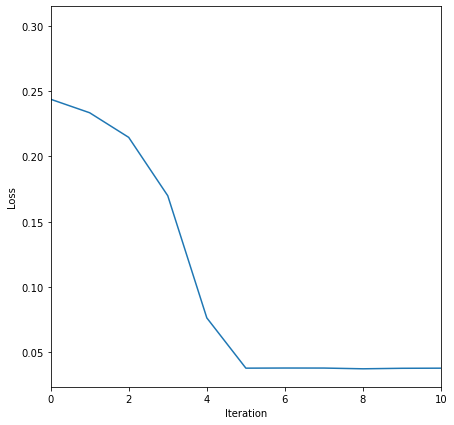

In [20]:
model = AutoEncoder().to(device)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

total_epoch = 10
record_loss = []

for epoch in range(total_epoch):
    print("Epoch: {}".format(epoch))
    for group in [train1_dataloader, train2_dataloader]:
        for images, _ in group:
            images = images.to(device).reshape(-1, 3 * 28 * 28)
            outputs = model(images)
            loss = loss_function(outputs, images)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            record_loss.append(loss.item())
    for group in [test_dataloader]:
        for images, _ in group:
            images = images.to(device).reshape(-1, 3 * 28 * 28)
            outputs = model(images)
            loss = 8.0 * loss_function(outputs, images)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            record_loss.append(loss.item())

plt.figure(figsize=(7, 7))
plt.plot(record_loss[:])
plt.xlim((0, total_epoch))
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [21]:
model.cpu()

inputs = train1_dataset.images.reshape((20000, -1)).to(torch.float32)
train1_x = model.encoder(inputs).detach().numpy()
train1_y = train1_dataset.targets.detach().numpy()

inputs = train2_dataset.images.reshape((20000, -1)).to(torch.float32)
train2_x = model.encoder(inputs).detach().numpy()
train2_y = train2_dataset.targets.detach().numpy()

train_x = np.concatenate((train1_x, train2_x), axis=0)
train_y = np.concatenate((train1_y, train2_y), axis=0)

inputs = test_dataset.images.reshape((20000, -1)).to(torch.float32)
test_x = model.encoder(inputs).detach().numpy()
test_y = test_dataset.targets.detach().numpy()

classifier = RandomForestClassifier(n_estimators=20)
classifier.fit(train_x, train_y)
predict_y = classifier.predict(test_x)
print("Accuracy: {}".format(metrics.accuracy_score(predict_y, test_y)))

Accuracy: 0.5033
